## Problem Set 2, Solution
**Stats 507, Fall 2021**  
*James Henderson, PhD*  
*October 5, 2021*


## Contents
+ [Question 0](#Question-0)
+ [Question 1](#Question-1)
+ [Question 2](#Question-2)
+ [Question 3](#Question-3)

## Question 0
In this question, you were asked to organize data and information related to
the Residential Energy Consumption Survey ([RECS][recs]) in preparation for
analyses in subsequent questions.  

### Data Files
 The data files in csv format are accessed by appending the following
 paths to this stem: https://www.eia.gov/consumption/residential/data/.
 + 2009 RECS:
   - [Data][recs09]: 2009/csv/recs2009_public.csv
   - [Replicate Weights][brr09]: 2009/csv/recs2009_public_repweights.csv
 + 2015 RECS:
   - [Data][recs15]: 2015/csv/recs2015_public_v4.csv
   - Replicate weights are included in the file above. 

[recs09]: https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv
[brr09]: https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv
[recs15]: https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv

### Variables
 Next, we identify the variables needed to answer the question below.

> Estimate the average number of heating and cooling degree days (base
> temperature 65 °F) for residences in each Census region for both 2009
> and 2015.

We will make use of:
 - `DOEID` - unique identifier for each sampled household,
 - `NWEIGHT` - final sample weight for each household,
 - `REGIONC` - Census region,
 - `CDD65` - cooling degree days, base temperature 65 °F,
 - `HDD65` - heating degree days, base temperautre 65 °F,
 - `brr_weight_*` - balance repeated replicate weights for 2009,
 - `BRRWT*` - balance repeated replicate weights for 2015. 
 
### Weights and Replicate Weights

In this data set, the final sample weights (`NWEIGHT`) should be used 
to account for the survey design and make estimates nationally (or
regionally) representative. For instance, to estimate the mean of variable 
$X$ in the population using these data, we use:

$$
\hat{\theta} = \hat{\theta}(w) = 
 \frac{\sum_{i=1}^n w_i X_i}{\sum_{i=1}^n w_i},
$$

where $i = 1, \cdots, n$ indexes the samples or cases, 
$X_i$ is the variable of interest for the $i^{th}$ case and 
$w_i$ the associated final sample weight. 


Rather than providing the full sampling design,
the survey is distributed with [balance repeated replicate weights][brr]. 
Details on using these weights for variance estimation are provided in 
the [technical documents][recstd] accompanying the data files.  

From these documents we learn that the varaince of the point estimate
$\hat{\theta}$ above can be estimated using the $R$ replicate weights
$w_i(1), \cdots w_i(R)$, by each set of replicate weights to create 
replicate estimetes $\hat{\theta}_r = \hat{\theta}(w(r))$:

$$
\hat{V}(\hat{\theta}) = \frac{1}{R(1 - \epsilon)^2} 
 \sum_{i=1}^R (\hat{\theta}_r - \hat{\theta}(w))^2. 
$$

Here $\epsilon = 0.5$ is the *Fay* coefficient which is determined by
how the replicate weights were formed from the balanced repeated 
half-samples. 

We can then form 95% confidence intervals around our estimates using
$\hat{\theta} \pm \Phi^{-1}(0.975) \sqrt{\hat{V}(\hat{\theta})}$. 


[brr]: https://journals-sagepub-com.proxy.lib.umich.edu/doi/pdf/10.1177/096228029600500305
[recstd]: https://www.eia.gov/consumption/residential/data/2015/pdf/microdata_v3.pdf


## Imports
We will use the following imports in this assignment.

In [1]:
# modules: --------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from collections import defaultdict
from os.path import exists
from scipy.stats import norm
from IPython.core.display import display, HTML
# 79: -------------------------------------------------------------------------

## Question 1 - Data Preparation

In this question we clean and prepare the 2009 and 2015 data by extracting
the minimum necessary columns and giving them memorable (lower-case) names. 

### part a) Download and clean data

In [2]:
# raw data files
stem = 'https://www.eia.gov/consumption/residential/data/'
recs09_file = stem + '2009/csv/recs2009_public.csv'
brr09_file = stem + '2009/csv/recs2009_public_repweights.csv'
recs15_file = stem + '2015/csv/recs2015_public_v4.csv'

recs09_local = 'ps3_recs09.feather'
recs09_brr = 'recs09_brr.feather'
recs15_local = 'ps3_recs15.feather'
recs15_brr = 'recs15_brr.feather'

# columns needed
core_cols_map = {
    'DOEID': 'id',
    'REGIONC': 'region',
    'NWEIGHT': 'weight',
    'HDD65': 'hdd65',
    'CDD65': 'cdd65'
}
core_cols = list(core_cols_map.keys())

# weight columns
wts09 = {'DOEID': 'id'}
wts09.update({'brr_weight_' + str(i): 'rwt' + str(i) for i in range(1, 245)})

wts15 = {'DOEID': 'id'}
wts15.update({'BRRWT' + str(i): 'rwt' + str(i) for i in range(1, 97)})
                 
# categorical labels (CHECK)
region = {1:'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}

# 2009 
if exists(recs09_local):
    recs09 = pd.read_feather(recs09_local)
else: 
    # 2009 RECS Data
    recs09 = pd.read_csv(recs09_file, low_memory=False)
    recs09 = recs09[core_cols]
    recs09.rename(columns=core_cols_map, inplace=True)
    
    # save
    recs09.to_feather(recs09_local)

if exists(recs09_brr):
    brr09 = pd.read_feather(recs09_brr)
else:
    # eplicate Weights
    brr09 = pd.read_csv(brr09_file)
    brr09.drop(columns='NWEIGHT', inplace=True)
    brr09.rename(columns=wts09, inplace=True)
    
    # save
    brr09.to_feather(recs09_brr)
    
# 2015
if exists(recs15_local) and exists(recs15_brr):
    recs15 = pd.read_feather(recs15_local)
    brr15 = pd.read_feather(recs15_brr)
else: 
    # 2009 RECS Data
    recs15 = pd.read_csv(recs15_file, low_memory=False)
    brr15 = recs15[wts15]
    brr15.rename(columns=wts_15, inplace=True)
    recs15 = recs15[core_cols]
    recs15.rename(columns=core_cols_map, inplace=True)
    
    # save
    recs15.to_feather(recs15_local)
    brr15.to_feather(recs15_brr)

### part b) Convert weights to a longer format
In the second part of this question, we convert the weights
to a longer format to faciliate use of `.groupby()` operations
for computing the replicate estimates. It'd probably be a good idea
to do this and part "a" together, and save the replicate weights in
this longer format.

In [3]:
# reshape 2009 weights to long
_ = wts09.pop('DOEID')
brr09 = brr09.melt(
    id_vars='id',
    value_vars=wts09.values(),
    value_name='rw',
    var_name='repl'
)
#brr09.set_index('id', inplace=True)

# reshape 2015 weights to long
_ = wts15.pop('DOEID')
brr15 = brr15.melt(
    id_vars='id',
    value_vars=wts15.values(),
    value_name='rw',
    var_name='repl'
)
#brr15.set_index('id', inplace=True)


## Question 2
In this question we compute estimates of the average heating
and cooling degree days (base 65 °F) by Census region.

### a) average heating and cooling degree days by region
In this part we compute estimates (and 95% confidence intervals) for the 
average heating and cooling degrees in 2009 and 2015.

In [4]:
# 79: -------------------------------------------------------------------------
fay = 1 / (1 - 0.5)
z = norm.ppf(.975)

# average these variables within region
dd65 = ['hdd65', 'cdd65']

# nicer labels for tables
dd_nice = {'hdd65': 'HDD (°65)', 'cdd65': 'CDD (°65)'}

# loop over the two years 
dd_summaries = []
for df, wts, i in zip([recs09, recs15], [brr09, brr15], [0, 1]):

    # normalize weights
    df['w'] = (
        df
        .groupby('region')['weight']
        .transform(lambda x: x / np.sum(x))
    )
    
    wts = pd.merge(wts, df, on='id')
    wts['w'] = (
        wts
        .groupby(['region', 'repl'])['rw']
        .transform(lambda x: x / np.sum(x))
    )
    
    # weight variables
    for v in dd65:
        df[v] = df[v] * df['w']
        wts[v] = wts[v] * wts['w']
        
    # point estimates
    est = df.groupby('region')[dd65].sum()
    
    # replicate estimates
    reps = wts.groupby(['region', 'repl'])[dd65].sum()
    
    # standard error
    reps = pd.merge(reps, est, how='left', on='region', suffixes=('_r', '_0'))

    for v in dd65:
        reps[v + '_se'] = (
            (reps[v + '_r'] - reps[v + '_0'])
            .transform(lambda x: np.power(x, 2))
        )
    
    dd65_se = [v + '_se' for v in dd65]    
    se = reps.groupby('region')[dd65_se].mean()
    
    for v in dd65_se:
        se[v] = se[v].transform(lambda x: fay * np.sqrt(x))
    
    # confidence intervals
    est = est.join(se, on='region')

    for v, v_se in zip(dd65, dd65_se):
        est[v + '_lwr'] = est[v] - z * est[v_se]
        est[v + '_upr'] = est[v] + z * est[v_se]
    
    dd_summaries.append(est)

Now we're ready to format the confidence intervals and construct a table. 

In [5]:
# nicer labels for tables
dd_nice = {'hdd65': '<center> HDD [65 °F] (95% CI) </center>',
           'cdd65': '<center> CDD [65 °F] (95% CI) </center>'}

# format confidence intervals
for v in dd65: 
    cols = {v: 'est', v + '_lwr': 'lwr', v + '_upr': 'upr'}
    for i, _ in enumerate(dd_summaries):
        df = dd_summaries[i][cols.keys()].rename(columns=cols)
        dd_summaries[i][dd_nice[v]] = (
            df
            .groupby(['region'])
            .apply(lambda x: 
                   '<center> {0:.0f}<br>({1:.0f}, {2:.0f}) </center>'.format(
                            x['est'].values[0],
                            x['lwr'].values[0],
                            x['upr'].values[0])
                  )
        )

In [6]:
# organize as a table
table1 = []
for i, yr in enumerate([2009, 2015]):
    tab = dd_summaries[i][dd_nice.values()]         
    tab.columns = pd.MultiIndex.from_tuples(
        [(c, '<center>' + str(yr) + '</center>') for c in tab.columns]
    )
    table1.append(tab)

table1 = pd.merge(
    table1[0], 
    table1[1], 
    on = 'region'
).sort_index(level=0, axis=1)
table1.index.name = 'Census Region'

In [7]:
# add a caption: --------------------------------------------------------------
cap = """
<caption style="text-align:justify; caption-side:bottom"> <b> Table 1.</b> 
<em> Average Cooling and Heating Degree Days, 2009 and 2015.</em>
This table shows the estimated cooling and heating degree days, base 
temperature 65 °F, experienced by US residences in each Census region in 2009 
and 2015. Values are estimated using data from the residential energy
consumption survey. CDD = cooling degree days, HDD = heating degree days. 
</caption>
"""
t1 = table1.to_html(justify='center', escape=False)
t1 = t1.rsplit('\n')
t1.insert(1, cap)
t1.insert(0, '<center>')
tab1 = ''
for line in t1:
    tab1 += line + '\n'
tab1 += '</center>'
tab1 = tab1.replace('<table', '<table width="100%"')
display(HTML(tab1))

### b) differences between 2015 and 2009
In this next part we compute differences in cooling and heating degree days between 2015 and 2009. 

In [8]:
# construct differences and standard errors
diffs = []
for v, s in zip(dd65, dd65_se):
    diff = dd_summaries[1][v] - dd_summaries[0][v]
    se = (
        dd_summaries[1][[s]].transform(lambda x: np.power(x, 2)) + 
        dd_summaries[0][[s]].transform(lambda x: np.power(x, 2))
    )
    se = se.transform(np.sqrt)
    df = pd.merge(diff, se, on='region')
    df[v + '_lwr'] = df[v] - z * df[s]
    df[v + '_upr'] = df[v] + z * df[s]
    diffs.append(df)
table2 = pd.merge(diffs[0], diffs[1], on='region')

# format confidence intervals
t2_nice = {
    'hdd65': '<center> HDD [65 °F] <br> 2015 less 2009 <br> (95% CI)</center>',
    'cdd65': '<center> CDD [65 °F] <br> 2015 less 2009 <br> (95% CI)</center>'
}
for v in dd65: 
    cols = {v: 'est', v + '_lwr': 'lwr', v + '_upr': 'upr'}
    df = table2[cols.keys()].rename(columns=cols)
    table2[t2_nice[v]] = (
        df
        .groupby(['region'])
        .apply(lambda x: 
                '<center> {0:.0f}<br>({1:.0f}, {2:.0f}) </center>'.format(
                        x['est'].values[0],
                        x['lwr'].values[0],
                        x['upr'].values[0])
                )
        )   
tab2 = table2[t2_nice.values()].iloc[:, [1, 0]]

# add a caption: --------------------------------------------------------------
cap2 = """
<caption style="text-align:justify; caption-side:bottom"> <b> Table 2.</b> 
<em> Average Cooling and Heating Degree Day Differences, 2015 less 2009.</em>
This table shows the estimated difference, 2015 less 2009, in cooling and
heating degree days, base temperature 65 °F, experienced by US residences 
in each Census region. Values are estimated using data from the residential
energy consumption survey. CDD = cooling degree days, HDD = heating degree days. 
</caption>
"""
t2 = tab2.to_html(justify='center', escape=False)
t2 = t2.rsplit('\n')
t2.insert(1, cap2)
t2.insert(0, '<center>')
tab2 = ''
for line in t2:
    tab2 += line + '\n'
tab2 += '</center>'
tab2 = tab2.replace('<table', '<table width="100%"')
display(HTML(tab2))

,CDD [65 °F] 2015 less 2009 (95% CI),HDD [65 °F] 2015 less 2009 (95% CI)
region,,
1,"303(235, 371)","-5(-183, 172)"
2,"295(227, 363)","-540(-716, -363)"
3,"432(304, 561)","-485(-660, -309)"
4,"248(40, 456)","-445(-698, -192)"


## Question 3

In this question we create visualizations of the estimates from the previous question. 

In [9]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

Here is a figure showing the estimated cooling and heating
degree days from part a of question 2.

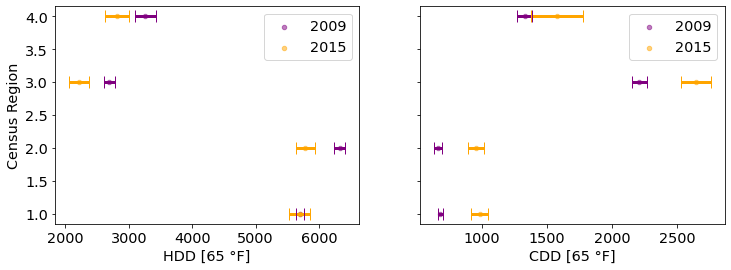

In [10]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, sharey=True)
_ = fig1.set_size_inches(12, 4)
yrs, colors = ('2009', '2015'), ('purple', 'orange')
labels = {'hdd65': 'HDD [65 °F]', 'cdd65': 'CDD [65 °F]'}
for i in 0, 1:
    df = dd_summaries[i].copy()
    df.reset_index(inplace=True)
    for j, v in enumerate(dd65): 
        (df
         .plot
         .scatter(
             ax=ax1[j],
             x=v,
             y='region',
             color=colors[i],
             alpha=0.5,
             label=yrs[i]
         )
        )
        ax1[j].errorbar(
            x=df[v], 
            y=df['region'],
            xerr=z * df[dd65_se[j]],
            color=colors[i],
            capsize=6,
            fmt='None',
            linewidth=3
        )
        if i == 1:
            ax1[j].legend(loc='upper right')
        ax1[j].set_xlabel(labels[v])
        ax1[j].set_ylabel('Census Region')

Here is a visualization of the differences from part b. 

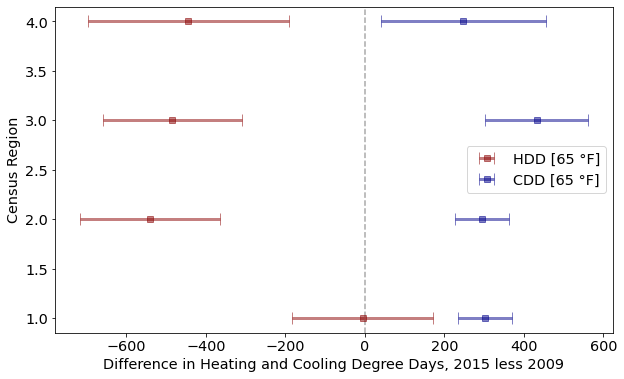

In [11]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1)
_ = fig2.set_size_inches(10, 6)
df = table2[dd65 + dd65_se].copy()
df.reset_index(inplace=True)
colors = {'hdd65': 'darkred', 'cdd65': 'darkblue'}
ax2.axvline(x=0, linestyle='--', color='darkgrey')
for j, v in enumerate(dd65): 
    ax2.errorbar(
        x=df[v], 
        y=df['region'],
        xerr=z * df[dd65_se[j]],
        capsize=6,
        alpha=0.5,
        color=colors[v],
        fmt='s',
        label=labels[v],
        linewidth=3
    )
_ = ax2.legend(loc='right')
_ = ax2.set_xlabel('Difference in Heating and Cooling Degree Days, 2015 less 2009')
_ = ax2.set_ylabel('Census Region')

---